# PhD-Paper-01-Eval
## José Belenguer Ballester
### Enlace del repositorio GitHub:
#### https://github.com/josebel78/PhD.git

## MODULE IMPORTS

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import warnings

In [11]:
warnings.filterwarnings("ignore")

## DATA LOADING

In [16]:
data_types = {'Alpha' : np.float32,	'T_limit' : np.int16, 'T_factor' : str, 'Makespan' : np.int32, 'Feasibility': np.bool_, 'Repair' : np.bool_, 
              'Time2best': np.float16, 'Sol2best': np.int16, 'Total_sol': np.int16, 'GRASP iter': np.int16, 
              'Construct_time': np.float16, 'Search_time': np.float16, 'Repair_time': np.float16}

parent_path = Path.cwd()

# Input data for this notebook are output data generated by the Cal and Test notebooks
input_data_path = parent_path / 'output_data'
input_debug_path = input_data_path / 'debug'
input_cal_path = input_data_path / 'cal'
input_test_small_path = input_data_path / 'test_small'
input_test_large_path = input_data_path / 'test_large'

# input_debug_path.mkdir(exist_ok=True)
# input_cal_path.mkdir(exist_ok=True)
# input_test_small_path.mkdir(exist_ok=True)
# input_test_large_path.mkdir(exist_ok=True)

# output_data_path = parent_path / 'output_data'
# output_debug_path = output_data_path / 'debug'
# output_cal_path = parent_path / 'output_data' / 'cal'
# output_test_small_path = parent_path / 'output_data' / 'test_small'
# output_test_large_path = parent_path / 'output_data' / 'test_large'

# output_data_path.mkdir(exist_ok=True)
# output_test_small_path.mkdir(exist_ok=True)
# output_test_large_path.mkdir(exist_ok=True)

instance_type = 'test_large' # 'debug', 'cal', 'test_small', 'test_large'

input_path = input_data_path / instance_type
files = [file.name for file in sorted(input_path.glob('*.csv'))]

print(f'\nInput data path: {input_path}')
print(f'\nFiles: {files}')

hue_order=[True, False]
palette = {True: 'green', False: 'red'}



Input data path: C:\Users\Usuario\Notebooks\PhD\Paper_01\output_data\test_large

Files: ['test_large_grasp0.csv', 'test_large_grasp1.csv', 'test_large_grasp2.csv', 'test_large_grasp3.csv', 'test_large_grasp4.csv']


# CALIBRATION

In [17]:

if input_path == input_debug_path:

    cal_df = pd.DataFrame()
    
    for file in files:
    
        os.chdir(input_path)
        
        file_name = file.rstrip('.csv')
            
        df = pd.read_csv(file, sep=';', header='infer', # names=machine_names,
                        index_col=0, # usecols=list(range(1,2*M,2)),
                        dtype=data_types, engine='python', # skiprows=skiprows_res, # skipfooter=skipfooter_res
                         decimal=',')
            
        num_instances = len(df.index)
        T_factor = df['T_factor'].unique()
        if len(T_factor) > 1:
            df['T_factor'] = ['m'] * num_instances
    
        cal_df = pd.concat([cal_df, df])
    
    cal_df.rename(columns={'Alpha': 'alpha', 'T_limit': 'Size'}, inplace=True)
    cal_df['n'] = [int(idx[:3]) for idx in cal_df.index]
    cal_df['m'] = cal_df['Size'] // cal_df['n']
    cal_df['Size_log'] = np.log10(cal_df['Size'])
    cal_df['Rel_sol2best'] = cal_df['Sol2best'] / cal_df['Total_sol'] * 100
    cal_df['Rel_time2best'] = cal_df['Time2best'] / cal_df['Size'] * 100
    cal_df['Rel_construct_time'] = cal_df['Construct_time'] / cal_df['Size'] * 100
    cal_df['Rel_search_time'] = cal_df['Search_time'] / cal_df['Size'] * 100
    cal_df['Rel_repair_time'] = cal_df['Repair_time'] / cal_df['Size'] * 100
    
    cal_df.sort_values(by=['Size','T_factor'], ascending=[True, False], inplace=True)

    output_path = os.path.join(input_path, 'fig')
    print(f'\nfile_path: {output_path}')
    fig_name_prefix = 'cal'
    os.chdir(output_path)
    
    ############################################################# INDIVIDUAL MAKESPAN PLOTS #############################################################
    
    unique_alphas = cal_df['alpha'].unique()

    for alpha in unique_alphas:
        alpha_data = cal_df[cal_df['alpha'] == alpha]

        g = sns.relplot(data=alpha_data, x="Size_log", y="Makespan", hue="Repair",
                        col='T_factor', height=5, aspect=1,
                        hue_order=hue_order, palette=palette)

        g.set_axis_labels("Instance size", "Makespan")
        x_labels = [5, 50, 500, 5000]
        g.set(xticks=np.log10(x_labels), xticklabels=x_labels)
        
        for ax, t_factor in zip(g.axes.flat, alpha_data['T_factor'].unique()):
            ax.set_title(f"alpha = {alpha} | T_factor = {t_factor}")
        
        fig_name = fig_name_prefix + f'_makespan_alpha_{alpha}.png'
        g.savefig(fig_name)
        plt.show()    
    
    ############################################################# INDIVIDUAL RELATIVE SOL2BEST PLOTS #############################################################
    
    # Get unique values of 'alpha'
    unique_alphas = cal_df['alpha'].unique()

    # Iterate over each unique 'alpha' value
    for alpha in unique_alphas:
        # Filter data for the current 'alpha' value
        alpha_data = cal_df[cal_df['alpha'] == alpha]

        # Create relplot for the current 'alpha' value
        g = sns.relplot(data=alpha_data, x="Size_log", y="Rel_sol2best", hue="Repair",
                        col='T_factor', height=5, aspect=1,
                        hue_order=hue_order, palette=palette)

        # Set axis labels
        g.set_axis_labels("Instance size", "Sol2best / Total_sol (%)")
        x_labels = [5, 50, 500, 5000]
        g.set(xticks=np.log10(x_labels), xticklabels=x_labels)
        
        # Set title for each subplot
        for ax, t_factor in zip(g.axes.flat, alpha_data['T_factor'].unique()):
            ax.set_title(f"alpha = {alpha} | T_factor = {t_factor}")
        
        fig_name = fig_name_prefix + f'_sol2best_alpha_{alpha}.png'
        g.savefig(fig_name)
        plt.show()    
    
    ############################################################# INDIVIDUAL RELATIVE TIME2BEST PLOTS #############################################################
    
    # Get unique values of 'alpha'
    unique_alphas = cal_df['alpha'].unique()

    # Iterate over each unique 'alpha' value
    for alpha in unique_alphas:
        # Filter data for the current 'alpha' value
        alpha_data = cal_df[cal_df['alpha'] == alpha]

        # Create relplot for the current 'alpha' value
        g = sns.relplot(data=alpha_data, x="Size_log", y="Rel_time2best", hue="Repair",
                        col='T_factor', height=5, aspect=1,
                        hue_order=hue_order, palette=palette)

        # Set axis labels
        g.set_axis_labels("Instance size", "Time2best / Time_limit (%)")
        x_labels = [5, 50, 500, 5000]
        g.set(xticks=np.log10(x_labels), xticklabels=x_labels)
        
        # Set title for each subplot
        for ax, t_factor in zip(g.axes.flat, alpha_data['T_factor'].unique()):
            ax.set_title(f"alpha = {alpha} | T_factor = {t_factor}")
        
        fig_name = fig_name_prefix + f'_time2best_alpha_{alpha}.png'
        g.savefig(fig_name)
        plt.show()
    
    ############################################################# INDIVIDUAL CONSTRUCT TIME PLOTS #############################################################
    
    # Get unique values of 'alpha'
    unique_alphas = cal_df['alpha'].unique()

    # Iterate over each unique 'alpha' value
    for alpha in unique_alphas:
        # Filter data for the current 'alpha' value
        alpha_data = cal_df[cal_df['alpha'] == alpha]

        # Create relplot for the current 'alpha' value
        g = sns.relplot(data=alpha_data, x="Size_log", y="Rel_construct_time", hue="Repair",
                        col='T_factor', height=5, aspect=1,
                        hue_order=hue_order, palette=palette)

        # Set axis labels
        g.set_axis_labels("Instance size", "Construct_time / Time_limit (%)")
        x_labels = [5, 50, 500, 5000]
        g.set(xticks=np.log10(x_labels), xticklabels=x_labels)
        
        # Set title for each subplot
        for ax, t_factor in zip(g.axes.flat, alpha_data['T_factor'].unique()):
            ax.set_title(f"alpha = {alpha} | T_factor = {t_factor}")
        
        fig_name = fig_name_prefix + f'_construct_time_alpha_{alpha}.png'
        g.savefig(fig_name)
        plt.show()
    
    ############################################################# INDIVIDUAL SEARCH TIME PLOTS #############################################################
    
    # Get unique values of 'alpha'
    unique_alphas = cal_df['alpha'].unique()

    # Iterate over each unique 'alpha' value
    for alpha in unique_alphas:
        # Filter data for the current 'alpha' value
        alpha_data = cal_df[cal_df['alpha'] == alpha]

        # Create relplot for the current 'alpha' value
        g = sns.relplot(data=alpha_data, x="Size_log", y="Rel_search_time", hue="Repair",
                        col='T_factor', height=5, aspect=1,
                        hue_order=hue_order, palette=palette)

        # Set axis labels
        g.set_axis_labels("Instance size", "Search_time / Time_limit (%)")
        x_labels = [5, 50, 500, 5000]
        g.set(xticks=np.log10(x_labels), xticklabels=x_labels)
        
        # Set title for each subplot
        for ax, t_factor in zip(g.axes.flat, alpha_data['T_factor'].unique()):
            ax.set_title(f"alpha = {alpha} | T_factor = {t_factor}")
        
        fig_name = fig_name_prefix + f'_search_time_alpha_{alpha}.png'
        g.savefig(fig_name)
        plt.show()
    
    ############################################################# INDIVIDUAL REPAIR TIME PLOTS #############################################################
    
    # Get unique values of 'alpha'
    unique_alphas = cal_df['alpha'].unique()

    # Iterate over each unique 'alpha' value
    for alpha in unique_alphas:
        # Filter data for the current 'alpha' value
        alpha_data = cal_df[cal_df['alpha'] == alpha]

        # Create relplot for the current 'alpha' value
        g = sns.relplot(data=alpha_data, x="Size_log", y="Rel_repair_time", hue="Repair",
                        col='T_factor', height=5, aspect=1,
                        hue_order=hue_order, palette=palette)

        # Set axis labels
        g.set_axis_labels("Instance size", "Repair_time / Time_limit (%)")
        x_labels = [5, 50, 500, 5000]
        g.set(xticks=np.log10(x_labels), xticklabels=x_labels)
        
        # Set title for each subplot
        for ax, t_factor in zip(g.axes.flat, alpha_data['T_factor'].unique()):
            ax.set_title(f"alpha = {alpha} | T_factor = {t_factor}")
        
        fig_name = fig_name_prefix + f'_repair_time_alpha_{alpha}.png'
        g.savefig(fig_name)
        plt.show()    
    
    os.chdir(parent_path)


# TEST

Reading test_large_grasp0
Reading test_large_grasp1
Reading test_large_grasp2
Reading test_large_grasp3
Reading test_large_grasp4

file_path: C:\Users\Usuario\Notebooks\PhD\Paper_01\output_data\test_large\fig


##################################################################### RPD Makespan Summary #####################################################################


RPD Cmax 0           RPD Cmax 1           RPD Cmax 2            \
             mean       std       mean       std       mean       std   
n   m                                                                   
50  10   1.413506  0.337081   0.043515  0.039942   0.008188  0.011637   
    15   1.697810  0.217528   0.028485  0.023569   0.010909  0.024393   
    20   1.569553  0.221314   0.000943  0.002109   0.169672  0.268733   
    25   1.691966  0.156422   0.006897  0.015421   0.076355  0.101451   
100 10   1.556878  0.330561   0.028507  0.023183   0.000000  0.000000   
    15   1.689103  0.235891   0.016389  0.019084   0.016402  0.028374   
    20   1.923797  0.298408   0.000475  0.001062   0.018798  0.026310   
    25   1.699690  0.192733   0.000623  0.001393   0.009731  0.009157   
150 10   1.430985  0.181231   0.013968  0.011771   0.002717  0.005435   
    15   1.900936  0.312082   0.018977  0.014107   0.003107  0.006947   
    20   1.776506  0.065579   0.020450  0.018876   0.004125  0.008251   
    25   1.870950  0.272600   0.005972  0.008827   0.011040  0.024687   
200 10   1.550421  0.285114   0.000000  0.000000   0.015907  0.009930   
    15   2.035952  0.108284   0.000569  0.001272   0.008134  0.011026   
    20   1.951728  0.332086   0.007547  0.010351   0.002023  0.004523   
    25   2.313645  0.198686   0.008653  0.011855   0.012095  0.012734   

       RPD Cmax 3           RPD Cmax 4            
             mean       std       mean       std  
n   m                                             
50  10   0.386248  0.143560   0.087250  0.064365  
    15   0.419105  0.113871   0.119930  0.070457  
    20   0.578456  0.047482   0.140709  0.036313  
    25   0.567367  0.037429   0.344330  0.255507  
100 10   0.441736  0.081812   0.254595  0.056676  
    15   0.535555  0.086274   0.234825  0.062583  
    20   0.506491  0.057741   0.319858  0.113603  
    25   0.553452  0.045770   0.323182  0.107424  
150 10   0.490698  0.100657   0.426546  0.128468  
    15   0.519680  0.048865   0.510848  0.072891  
    20   0.590381  0.034994   0.456795  0.094671  
    25   0.623454  0.057843   0.477648  0.068572  
200 10   0.439013  0.121386   0.432244  0.063427  
    15   0.513823  0.049038   0.465264  0.075486  
    20   0.562322  0.083027   0.483642  0.058500  
    25   0.632507  0.045247   0.583290  0.045512



####################################################################### RPD Time Summary #######################################################################


RPD Time 0           RPD Time 1           RPD Time 2            \
             mean       std       mean       std       mean       std   
n   m                                                                   
50  10   0.202223  0.079601   0.003121  0.004642  24.322176  0.129199   
    15   0.416775  0.084716   0.000472  0.001055  25.884610  0.298558   
    20   0.295175  0.044864   0.000000  0.000000  23.594320  0.183227   
    25   0.342412  0.074060   0.000000  0.000000  23.463195  0.273918   
100 10   0.491951  0.218710   0.000000  0.000000  27.074591  0.484450   
    15   0.387818  0.142432   0.000000  0.000000  22.350364  0.534458   
    20   0.285105  0.167722   0.000000  0.000000  26.009700  0.415806   
    25   0.228301  0.153824   0.000000  0.000000  24.220408  0.592194   
150 10   0.774406  0.200859   0.000000  0.000000  29.425997  1.148916   
    15   0.449559  0.206543   0.000633  0.001414  27.166124  0.926808   
    20   0.636073  0.461113   0.000000  0.000000  23.692309  1.148317   
    25   0.851564  0.530356   0.000000  0.000000  20.994788  0.997053   
200 10   0.630810  0.293906   0.000000  0.000000  22.071105  0.382779   
    15   0.506466  0.180284   0.000000  0.000000  31.604529  0.557266   
    20   0.873505  0.579894   0.005024  0.011233  26.054722  0.649452   
    25   1.154975  0.667879   0.000000  0.000000  24.447852  1.501992   

       RPD Time 3           RPD Time 4            
             mean       std       mean       std  
n   m                                             
50  10   0.026836  0.029282  25.366458  0.589062  
    15   0.038260  0.023450  25.999235  0.318335  
    20   0.049239  0.013879  23.963618  0.233401  
    25   0.050259  0.030814  23.680983  0.364638  
100 10   0.034028  0.017604  27.198374  0.591131  
    15   0.127094  0.074239  22.509832  0.462118  
    20   0.050468  0.041522  26.310117  0.681585  
    25   0.075439  0.061857  24.113678  0.467782  
150 10   0.148062  0.080480  29.452550  1.384502  
    15   0.055254  0.045279  26.969566  0.706592  
    20   0.165543  0.031150  23.766540  1.123286  
    25   0.154476  0.133353  21.219712  0.996373  
200 10   0.097304  0.109584  22.189857  0.430725  
    15   0.078525  0.079014  31.590197  0.522105  
    20   0.087407  0.075996  26.332564  0.559493  
    25   0.198042  0.116694  24.376942  1.543964



########################################################### Best Absolute Makespan and Time Summary ############################################################


Cmax 0                  Time 0              Cmax 1              \
           mean         std        mean         std    mean         std   
n   m                                                                     
50  10   514.80   14.394443   10.890625    0.714406  225.20   25.810850   
    15   537.60   31.690693   18.546875    1.130790  205.60   15.159156   
    20   508.80   29.499153   22.840625    0.841534  199.20   17.711578   
    25   520.80   39.795728   29.053125    1.503844  195.40   19.112823   
100 10  1104.80   70.510283   34.134375    4.577746  449.20   53.190225   
    15  1084.00   53.447794   47.500000    5.439356  412.75   49.681485   
    20  1005.60   37.792856   57.568750    7.550462  347.40   43.125399   
    25  1017.00   43.399309   67.962500    9.427209  378.60   32.106074   
150 10  1741.75   42.750244   72.171875    7.585858  728.50   35.856194   
    15  1639.60   32.160535   85.825000   14.767826  581.80   69.718721   
    20  1662.75   63.442231  131.187500   39.924734  611.00   16.693312   
    25  1616.20   50.291152  188.012500   61.309576  570.60   58.414895   
200 10  2183.60   73.697354   96.550000   16.815253  866.00  113.743132   
    15  2108.00   32.764310  130.237500   16.125872  695.20   17.469974   
    20  2168.60   49.712172  221.150000   71.717676  747.40   81.775913   
    25  2166.40  165.915038  334.550000  115.651335  661.40   68.500365   

            Time 1             Cmax 2                Time 2             \
              mean        std    mean         std      mean        std   
n   m                                                                    
50  10    9.087500   0.077812  217.80   25.762376   229.400   2.138560   
    15   13.096875   0.161400  202.60   22.097511   351.900   0.418330   
    20   17.634375   0.120323  231.40   49.470193   433.700   3.650342   
    25   21.646875   0.243469  209.40   33.396108   529.500   1.457738   
100 10   22.912500   0.419932  437.00   53.000000   643.100   2.607681   
    15   34.195312   0.882547  413.00   51.684943   798.125   4.327721   
    20   44.800000   0.907219  353.20   38.388800  1209.800  15.188812   
    25   55.268750   1.104103  382.20   34.463024  1393.400   9.964939   
150 10   40.726562   1.911174  720.75   42.804789  1237.500   9.574271   
    15   59.062500   1.662870  572.40   64.515890  1661.600  37.878754   
    20   79.875000   3.842268  601.25   14.500000  1969.000   8.831761   
    25  100.512500   4.953574  572.20   44.098753  2206.800   9.959920   
200 10   59.281250   0.956066  880.40  121.742762  1367.400   5.412947   
    15   86.425000   1.474656  700.40   16.425590  2817.200   9.011104   
    20  118.137500   3.145061  743.20   79.822929  3178.800  23.392306   
    25  153.675000  10.237263  663.00   59.025418  3898.400  24.182638   

         Cmax 3                  Time 3              Cmax 4              \
           mean         std        mean        std     mean         std   
n   m                                                                     
50  10   301.00   56.240555    9.303125   0.304307   234.20   23.509573   
    15   284.80   41.901074   13.590625   0.304066   224.20   25.528416   
    20   314.20   29.894816   18.503125   0.311208   226.60   15.339492   
    25   304.20   30.930567   22.734375   0.701126   262.40   64.767276   
100 10   633.20  108.460592   23.690625   0.505753   550.20   86.560384   
    15   624.75   89.738045   38.585938   3.453691   499.50   40.681691   
    20   523.20   70.012142   47.056250   1.950861   457.40   61.076182   
    25   588.20   57.803114   59.481250   4.438193   502.40   71.936083   
150 10  1069.75   62.904027   46.742188   3.646789  1022.25   56.606095   
    15   869.80  127.071633   62.325000   4.073099   864.60  129.301199   
    20   952.25   28.605069   93.031250   3.078191   871.50   41.860881   
    25   920.40   93.820573  116.175000  15.885171   836.80   78.550621   
200 10  1242.60  156.535300   65.018750   6.131717 



################################################### Absolute Makespan and Time Comparison of Best Solutions ####################################################


Cmax 1                  Time 1             Cmax 2              \
          mean         std        mean        std    mean         std   
n   m                                                                   
50  10  225.20   25.810850    9.087500   0.077812  217.80   25.762376   
    15  205.60   15.159156   13.096875   0.161400  202.60   22.097511   
    20  199.20   17.711578   17.634375   0.120323  231.40   49.470193   
    25  195.40   19.112823   21.646875   0.243469  209.40   33.396108   
100 10  449.20   53.190225   22.912500   0.419932  437.00   53.000000   
    15  412.75   49.681485   34.195312   0.882547  413.00   51.684943   
    20  347.40   43.125399   44.800000   0.907219  353.20   38.388800   
    25  378.60   32.106074   55.268750   1.104103  382.20   34.463024   
150 10  728.50   35.856194   40.726562   1.911174  720.75   42.804789   
    15  581.80   69.718721   59.062500   1.662870  572.40   64.515890   
    20  611.00   16.693312   79.875000   3.842268  601.25   14.500000   
    25  570.60   58.414895  100.512500   4.953574  572.20   44.098753   
200 10  866.00  113.743132   59.281250   0.956066  880.40  121.742762   
    15  695.20   17.469974   86.425000   1.474656  700.40   16.425590   
    20  747.40   81.775913  118.137500   3.145061  743.20   79.822929   
    25  661.40   68.500365  153.675000  10.237263  663.00   59.025418   

          Time 2             
            mean        std  
n   m                        
50  10   229.400   2.138560  
    15   351.900   0.418330  
    20   433.700   3.650342  
    25   529.500   1.457738  
100 10   643.100   2.607681  
    15   798.125   4.327721  
    20  1209.800  15.188812  
    25  1393.400   9.964939  
150 10  1237.500   9.574271  
    15  1661.600  37.878754  
    20  1969.000   8.831761  
    25  2206.800   9.959920  
200 10  1367.400   5.412947  
    15  2817.200   9.011104  
    20  3178.800  23.392306  
    25  3898.400  24.182638

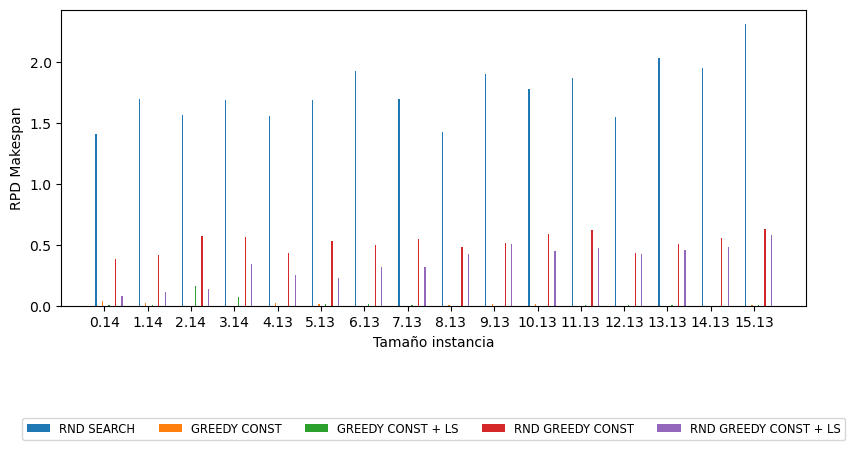

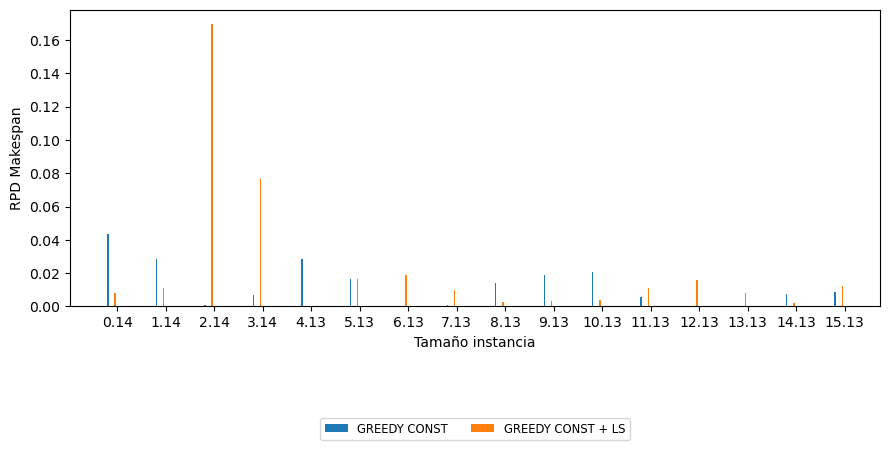

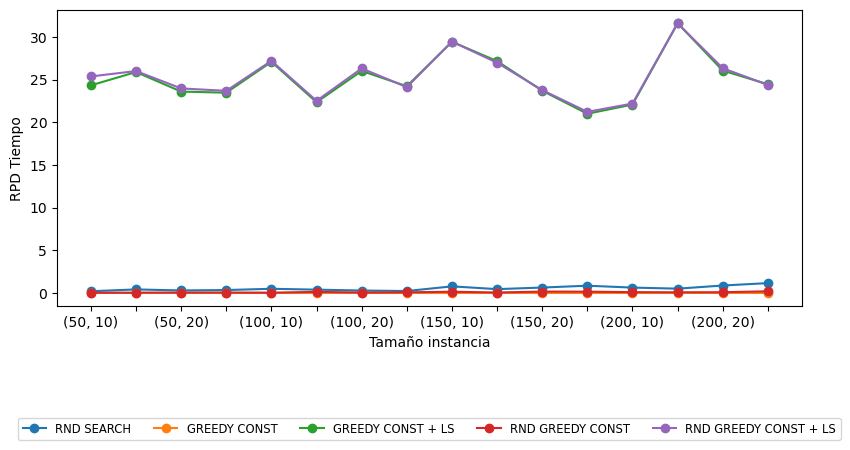

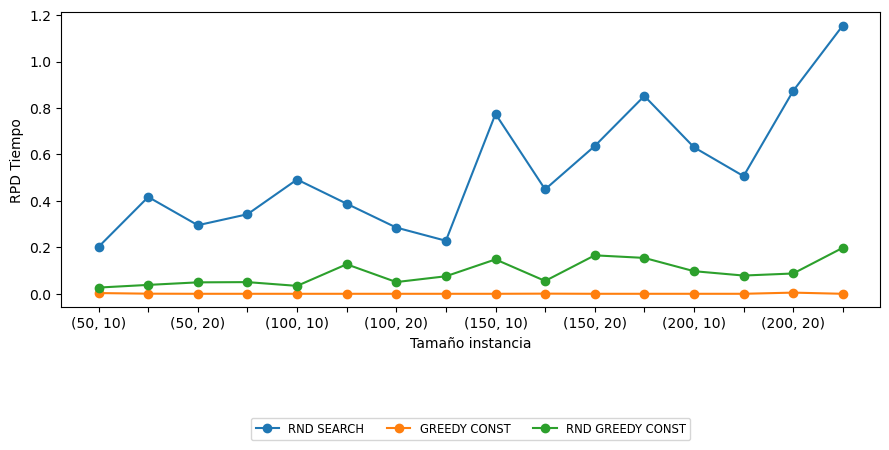

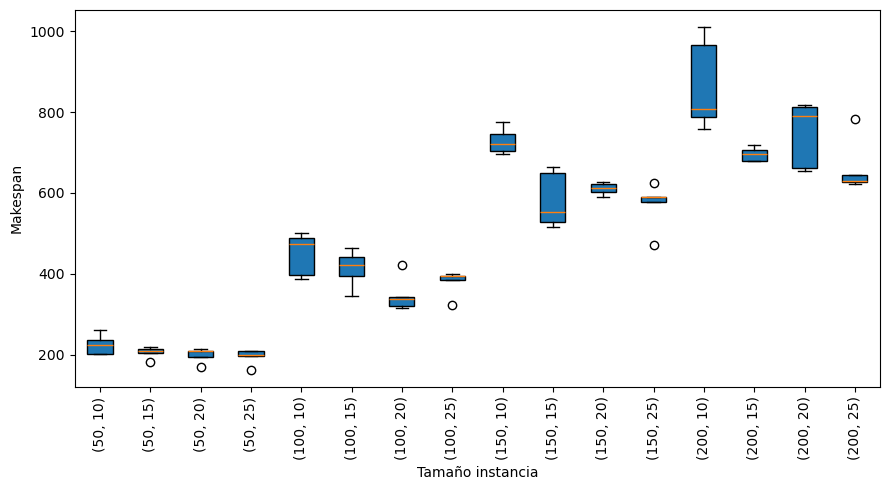

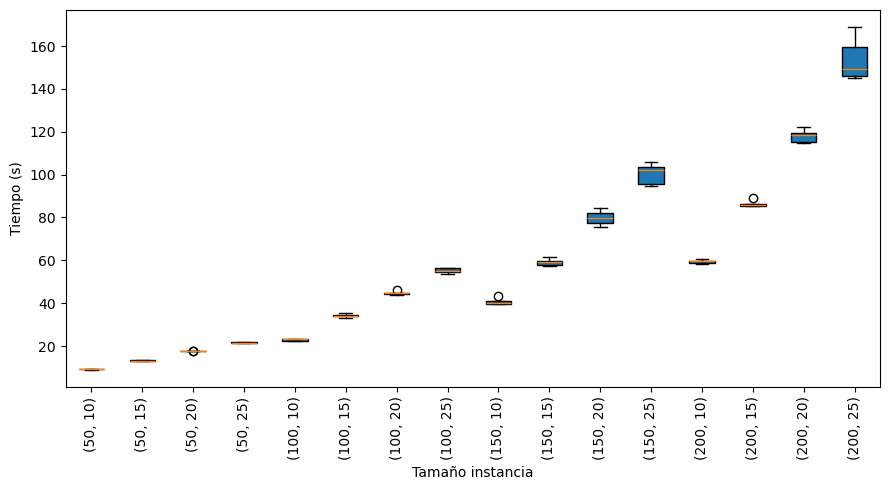

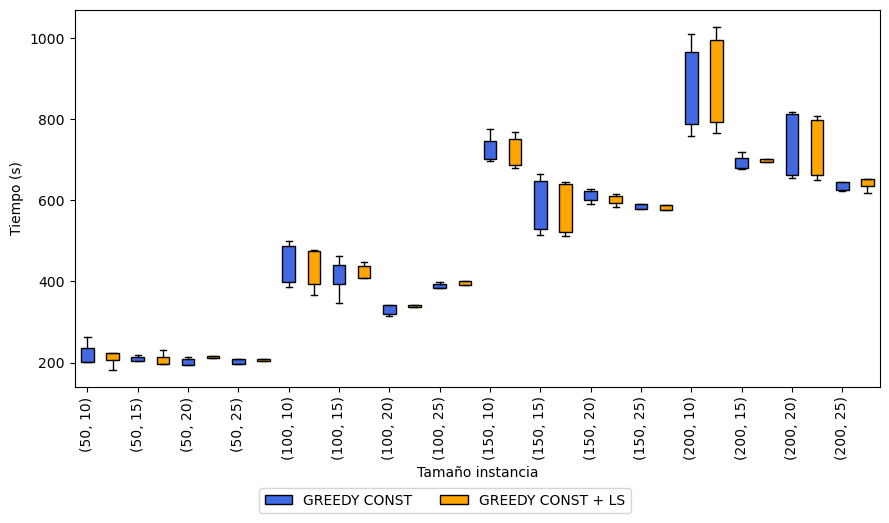

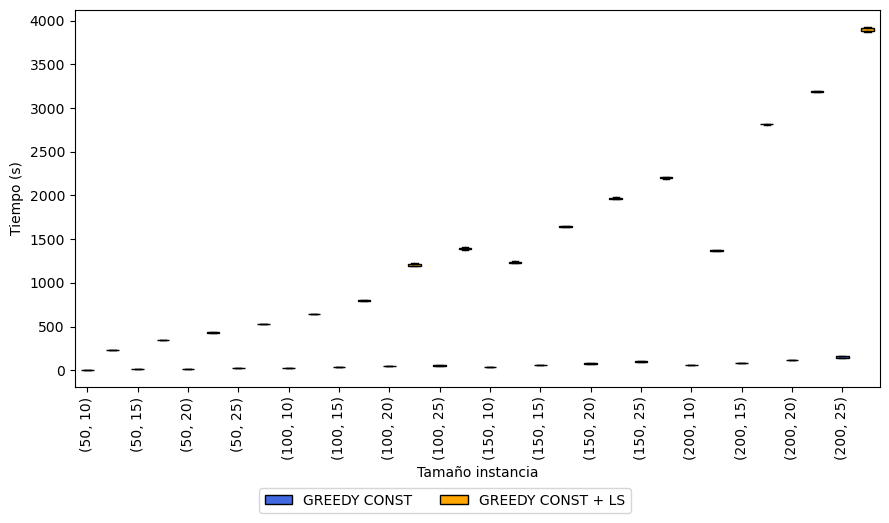

In [18]:

if (input_path == input_test_small_path) or (input_path == input_test_large_path):

    # Data structure prepraration

    test_summary_feasibility_df = pd.DataFrame()
    output_columns_feasibility = ['n', 'm', 'Feasibility']

    test_summary_c_abs_rnd_df = pd.DataFrame()
    test_summary_c_abs_df = pd.DataFrame()
    output_columns_c_abs = ['n', 'm', 'Cmax']

    test_summary_c_rel_rnd_df = pd.DataFrame()
    test_summary_c_rel_df = pd.DataFrame()
    output_columns_c_rel = ['n', 'm', 'RPD Cmax']

    test_summary_c_abs_rel_df = pd.DataFrame()
    output_columns_c_abs_rel = ['n', 'm', 'Cmax', 'RPD Cmax']

    test_summary_t_abs_rnd_df = pd.DataFrame()
    test_summary_t_abs_df = pd.DataFrame()
    output_columns_t_abs = ['n', 'm', 'Time']

    test_summary_t_rel_rnd_df = pd.DataFrame()
    test_summary_t_rel_df = pd.DataFrame()
    output_columns_t_rel = ['n', 'm', 'RPD Time']

    test_summary_t_abs_rel_df = pd.DataFrame()
    output_columns_t_abs_rel = ['n', 'm', 'Time', 'RPD Time']

    test_summary_c_t_abs_df = pd.DataFrame()
    output_columns_c_t_abs = ['n', 'm', 'Cmax', 'Time']

    test_summary_c_t_rel_df = pd.DataFrame()
    output_columns_c_t_rel = ['n', 'm', 'RPD Cmax', 'RPD Time']

    grasp_variant_names = []
    
    for file_idx,file in enumerate(files):
    
        os.chdir(input_path)
        
        file_name = file.rstrip('.csv')
        print(f'Reading {file_name}\r')
        # grasp_variant_names.append(file_name[-6:])

        test_df = pd.DataFrame()
            
        test_df = pd.read_csv(file, sep=';', header='infer', index_col=0, dtype=data_types, engine='python', decimal=',')
        
        num_instances = len(test_df.index)
        T_factor = test_df['T_factor'].unique()
        if len(T_factor) > 1:
            test_df['T_factor'] = ['m'] * num_instances

        test_df = test_df[['Feasibility', 'Alpha', 'T_limit', 'T_factor', 'Repair', 'Makespan', 'Time2best']]
    
        test_df.rename(columns={'Alpha': 'alpha', 'T_limit': 'Size', 'Makespan': 'Cmax', 'Time2best': 'Time'}, inplace=True)
        test_df['n'] = [int(idx[:3]) for idx in test_df.index]
        test_df['m'] = test_df['Size'] // test_df['n']
        test_df['Time'].replace(0, 1e-2, inplace=True)
        test_df['Size_log'] = np.log10(test_df['Size'])
        test_df['RPD Cmax'] = np.inf*np.ones((len(test_df.index),))
        test_df['RPD Time'] = np.inf*np.ones((len(test_df.index),))

        test_df = test_df.loc[:, ['Feasibility', 'n', 'm', 'Size', 'Size_log', 'alpha', 'Cmax', 'RPD Cmax', 'Time', 'RPD Time']]
        test_df.sort_values(by=['n', 'm'], inplace=True)

        ############################################################# OUTPUT DATA #############################################################

        # Feasibility
        
        output_feasibility_df = test_df[output_columns_feasibility]
        output_feasibility_df.set_index(['n', 'm'], inplace=True)
        output_feasibility_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)
        
        if test_summary_feasibility_df.empty:
            test_summary_feasibility_df = output_feasibility_df
        else:
            test_summary_feasibility_df = pd.concat([test_summary_feasibility_df,output_feasibility_df], axis=1)

        # Absolute Makespan
        
        output_c_abs_df = test_df[output_columns_c_abs]
        output_c_abs_df.set_index(['n', 'm'], inplace=True)
        output_c_abs_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)
        
        if test_summary_c_abs_df.empty:
            test_summary_c_abs_df = output_c_abs_df
            test_summary_c_abs_rnd_df = output_c_abs_df
        else:
            test_summary_c_abs_df = pd.concat([test_summary_c_abs_df,output_c_abs_df], axis=1)
        
        # RPD Makespan
        
        output_c_rel_df = test_df[output_columns_c_rel]
        output_c_rel_df.set_index(['n', 'm'], inplace=True)
        output_c_rel_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)
        
        if test_summary_c_rel_df.empty:
            test_summary_c_rel_df = output_c_rel_df
            test_summary_c_rel_rnd_df = output_c_rel_df
        else:
            test_summary_c_rel_df = pd.concat([test_summary_c_rel_df,output_c_rel_df], axis=1)
        
        # Absolute + RPD Makespan
        
        output_c_abs_rel_df = test_df[output_columns_c_abs_rel]
        output_c_abs_rel_df.set_index(['n', 'm'], inplace=True)
        output_c_abs_rel_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)
            
        if test_summary_c_abs_rel_df.empty:
            test_summary_c_abs_rel_df = output_c_abs_rel_df
            test_summary_c_abs_rel_rnd_df = output_c_abs_rel_df
        else:
            test_summary_c_abs_rel_df = pd.concat([test_summary_c_abs_rel_df,output_c_abs_rel_df], axis=1)
        
        # Absolute Time
        
        output_t_abs_df = test_df[output_columns_t_abs]
        output_t_abs_df.set_index(['n', 'm'], inplace=True)
        output_t_abs_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)

        if test_summary_t_abs_df.empty:
            test_summary_t_abs_df = output_t_abs_df
            test_summary_t_abs_rnd_df = output_t_abs_df
        else:
            test_summary_t_abs_df = pd.concat([test_summary_t_abs_df,output_t_abs_df], axis=1)
        
        # RPD Time
        
        output_t_rel_df = test_df[output_columns_t_rel]
        output_t_rel_df.set_index(['n', 'm'], inplace=True)
        output_t_rel_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)
            
        if test_summary_t_rel_df.empty:
            test_summary_t_rel_df = output_t_rel_df
            test_summary_t_rel_rnd_df = output_t_rel_df
        else:
            test_summary_t_rel_df = pd.concat([test_summary_t_rel_df,output_t_rel_df], axis=1)
        
        # Absolute + RPD Time
        
        output_t_abs_rel_df = test_df[output_columns_t_abs_rel]
        output_t_abs_rel_df.set_index(['n', 'm'], inplace=True)
        output_t_abs_rel_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)
            
        if test_summary_t_abs_rel_df.empty:
            test_summary_t_abs_rel_df = output_t_abs_rel_df
            test_summary_t_abs_rel_rnd_df = output_t_abs_rel_df
        else:
            test_summary_t_abs_rel_df = pd.concat([test_summary_t_abs_rel_df,output_t_abs_rel_df], axis=1)
        
        # Absolute Makespan + Time
        
        output_c_t_abs_df = test_df[output_columns_c_t_abs]
        output_c_t_abs_df.set_index(['n', 'm'], inplace=True)
        output_c_t_abs_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)

        if test_summary_c_t_abs_df.empty:
            test_summary_c_t_abs_df = output_c_t_abs_df
            test_summary_c_t_abs_rnd_df = output_c_t_abs_df
        else:
            test_summary_c_t_abs_df = pd.concat([test_summary_c_t_abs_df,output_c_t_abs_df], axis=1)
        
        # RPD Makespan + Time
        
        output_c_t_rel_df = test_df[output_columns_c_t_rel]
        output_c_t_rel_df.set_index(['n', 'm'], inplace=True)
        output_c_t_rel_df.rename(columns=lambda x: f"{x} {file_idx}", inplace=True)

        if test_summary_c_t_rel_df.empty:
            test_summary_c_t_rel_df = output_c_t_rel_df
            test_summary_c_t_rel_rnd_df = output_c_t_rel_df
        else:
            test_summary_c_t_rel_df = pd.concat([test_summary_c_t_rel_df,output_c_t_rel_df], axis=1)

        del test_df
    
    ############################################################# FEASIBILITY CHECK #############################################################
    
    test_summary_feasibility_df['Feasibility'] = test_summary_feasibility_df.all(axis=1)
    feasibility_mask = test_summary_feasibility_df['Feasibility'] == True
    test_summary_c_abs_df = test_summary_c_abs_df[feasibility_mask]
    test_summary_c_rel_df = test_summary_c_rel_df[feasibility_mask]
    test_summary_c_abs_rel_df = test_summary_c_abs_rel_df[feasibility_mask]
    test_summary_t_abs_df = test_summary_t_abs_df[feasibility_mask]
    test_summary_t_rel_df = test_summary_t_rel_df[feasibility_mask]
    test_summary_t_abs_rel_df = test_summary_t_abs_rel_df[feasibility_mask]
    test_summary_c_t_abs_df = test_summary_c_t_abs_df[feasibility_mask]
    test_summary_c_t_rel_df = test_summary_c_t_rel_df[feasibility_mask]

    ############################################################# RPD CALCULATION #############################################################

    test_summary_c_abs_df['Best Cmax'] = test_summary_c_abs_df.min(axis=1)
    test_summary_t_abs_df['Best Time'] = test_summary_t_abs_df.min(axis=1)

    for i in range(len(test_summary_c_rel_df.columns)):
        test_summary_c_rel_df.iloc[:,i] = (test_summary_c_abs_df.iloc[:,i] - test_summary_c_abs_df.iloc[:,-1]) / test_summary_c_abs_df.iloc[:,-1]
        test_summary_t_rel_df.iloc[:,i] = (test_summary_t_abs_df.iloc[:,i] - test_summary_t_abs_df.iloc[:,-1]) / test_summary_t_abs_df.iloc[:,-1]


    ############################################################# OUPUT #############################################################

    output_path = os.path.join(input_path, 'fig')
    print(f'\nfile_path: {output_path}')
    fig_name_prefix = 'small' if (input_path == test_small_path) else 'large'
    os.chdir(output_path)
        
    # DATA SUMMARY PREPARATION

    # # Put together the values of Makespan and Time for the random seach
    # # print('\n\n' + str(' Random Summary ').center(160, '#')) # 483
    # # test_summary_abs_rnd_df = test_summary_c_abs_rnd_df.merge(test_summary_t_abs_rnd_df, left_index=True, right_index=True)
    # # test_summary_abs_rnd_df = test_summary_abs_rnd_df.groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    # # display(test_summary_abs_rnd_df)

    # Put together the values of Makespan for the GRASP variants
    # print('\n\n' + str(' Makespan Summary ').center(160, '#')) # 483
    # test_summary_c_abs_df_grouped = test_summary_c_abs_df.groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    # # display(test_summary_c_abs_df_grouped.iloc[:, 2:])
    # display(test_summary_c_abs_df_grouped.iloc[:, 0:])

    # Put together the values of RPD Makespan for the GRASP variants
    print('\n\n' + str(' RPD Makespan Summary ').center(160, '#')) # 483
    test_summary_c_rel_df_grouped = test_summary_c_rel_df.groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    # display(test_summary_c_rel_df_grouped.iloc[:, 2:])
    display(test_summary_c_rel_df_grouped.iloc[:, 0:])

    
    # # Put together the values of Time for the GRASP variants
    # # print('\n\n' + str(' Time Summary ').center(160, '#')) # 483
    # # test_summary_t_abs_df_grouped = test_summary_t_abs_df.groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    # # # display(test_summary_t_abs_df_grouped.iloc[:, 2:])
    # # display(test_summary_t_abs_df_grouped.iloc[:, 0:])
    
    # # Put together the values of RPD Time for the GRASP variants
    print('\n\n' + str(' RPD Time Summary ').center(160, '#')) # 483
    test_summary_t_rel_df_grouped = test_summary_t_rel_df.groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    # display(test_summary_t_rel_df_grouped.iloc[:, 2:])
    display(test_summary_t_rel_df_grouped.iloc[:, 0:])
    
    # Put together the RPD values of Makespan and Time for the summary of the GRASP variants
    # print('\n\n' + str(' RPD Summary ').center(160, '#')) # 483
    # test_summary_rel_df = test_summary_c_rel_df.merge(test_summary_t_rel_df, left_index=True, right_index=True)

    # c_columns = list(test_summary_rel_df.columns)[:len(files)]
    # t_columns = list(test_summary_rel_df.columns)[len(files):]
    # summmary_columns = []
    # for i in range(len(files)):
    #     summmary_columns.append(c_columns[i])
    #     summmary_columns.append(t_columns[i])

    # test_summary_rel_df = test_summary_rel_df[summmary_columns]
    # test_summary_rel_df_grouped = test_summary_rel_df.groupby(level=['n', 'm']).aggregate(np.mean)
    # display(test_summary_rel_df_grouped)

    
    # Put together the absolute values of Makespan and Time for the best GRASP variant
    print('\n\n' + str(' Best Absolute Makespan and Time Summary ').center(160, '#')) # 483
    best_summary_abs_df = pd.concat([test_summary_c_abs_df.iloc[:,:5],test_summary_t_abs_df.iloc[:,:5]], axis=1)
    best_columns = []
    for i in range(5):
        best_columns.append(test_summary_c_abs_df.columns[i])
        best_columns.append(test_summary_t_abs_df.columns[i])
    best_summary_abs_df = best_summary_abs_df[best_columns]
    best_summary_abs_df_grouped = best_summary_abs_df.groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    display(best_summary_abs_df_grouped)
    
    # Put together the absolute values of Makespan and Time for the best GRASP variant
    print('\n\n' + str(' Absolute Makespan and Time Comparison of Best Solutions ').center(160, '#')) # 483
    # best_summary_abs_df = pd.concat([test_summary_c_abs_df.iloc[:,:5],test_summary_t_abs_df.iloc[:,:5]], axis=1)
    # best_columns = []
    # for i in range(5):
    #     best_columns.append(test_summary_c_abs_df.columns[i])
    #     best_columns.append(test_summary_t_abs_df.columns[i])
    # best_summary_abs_df = best_summary_abs_df[best_columns]
    best_summary_abs_comp_df_grouped = best_summary_abs_df.iloc[:, 2:6].groupby(level=['n', 'm']).aggregate([np.mean, np.std])
    display(best_summary_abs_comp_df_grouped)

    # DATA PLOTS

    grasp_variant_names = ['RND SEARCH', 'GREEDY CONST', 'GREEDY CONST + LS', 
                           'RND GREEDY CONST', 'RND GREEDY CONST + LS']
    
    ############################################################# FIGURE 1 #############################################################
    
    # Figure 1: RPD Makespan of the 5 variants

    plt.close('all')

    mean_values_c_rel = test_summary_c_rel_df_grouped.iloc[:, ::2]

    fig1, ax1 = plt.subplots(1, 1, figsize=(9, 5))
    legend_titles = grasp_variant_names

    group_width = 0.15  # Width of each group of bars
    bar_width = 0.03  # Width of each individual bar
    x_values = np.arange(len(mean_values_c_rel.index))  # Create numerical x-values
    for i, column in enumerate(mean_values_c_rel.columns[:5]):
        x_offset = i * group_width - 2 * bar_width  # Calculate x-offset for each group
        ax1.bar(x_values + x_offset, mean_values_c_rel[column], width=bar_width, label=legend_titles[i])  # Adjust width and position
    
    ax1.set_xticks(x_values + group_width / 2 + 2 * bar_width) # Shift xticks to be centered on the third bar
    if input_path == test_small_path:
        ax1.set_xticklabels(mean_values_c_rel.index)  # Set x-tick labels
    elif input_path == test_large_path:
        ax1.set_xticklabels(mean_values_c_rel.index, rotation=90)  # Set x-tick labels    
    ax1.set_xlabel('Tamaño instancia')
    ax1.set_ylabel('RPD Makespan')
    
    plt.legend(bbox_to_anchor=(0.5, -0.45), loc='lower center', borderaxespad=0., ncol=5, fontsize='small')    
    
    plt.tight_layout()    
    fig_name = fig_name_prefix + '_grasp_makespan.png'
    plt.savefig(fig_name)
    plt.show()
    
    ############################################################# FIGURE 2 #############################################################
    
    # Figure 2: RPD Makespan of the 5 variants excluding the random search

    plt.close('all')

    # no_ls_indices = list(range(1,5))

    no_ls_indices = list(range(1,3))
    mean_values_c_rel = test_summary_c_rel_df_grouped.iloc[:, 2*np.array(no_ls_indices)]

    fig2, ax2 = plt.subplots(1, 1, figsize=(9, 5))
    legend_titles = [grasp_variant_names[i] for i in no_ls_indices]

    group_width = 0.15  # Width of each group of bars
    bar_width = 0.03  # Width of each individual bar
    x_values = np.arange(len(mean_values_c_rel.index))  # Create numerical x-values
    for i, column in enumerate(mean_values_c_rel.columns[:5]):
        x_offset = i * group_width - 2 * bar_width  # Calculate x-offset for each group
        ax2.bar(x_values + x_offset, mean_values_c_rel[column], width=bar_width, label=legend_titles[i])  # Adjust width and position

    ax2.set_xticks(x_values + group_width / 2 + 2 * bar_width) # Shift xticks to be centered on the third bar
    if input_path == test_small_path:
        ax2.set_xticklabels(mean_values_c_rel.index)  # Set x-tick labels
    elif input_path == test_large_path:
        ax2.set_xticklabels(mean_values_c_rel.index, rotation=90)  # Set x-tick labels    
    ax2.set_xlabel('Tamaño instancia')
    ax2.set_ylabel('RPD Makespan')
    
    plt.legend(bbox_to_anchor=(0.5, -0.45), loc='lower center', borderaxespad=0., ncol=5, fontsize='small')    
    
    plt.tight_layout()    
    fig_name = fig_name_prefix + '_grasp-rnd_makespan.png'
    plt.savefig(fig_name)
    plt.show()
    
    ############################################################# FIGURE 3 #############################################################
    
    # Figure 3: RPD Time of the 5 variants

    plt.close('all')

    mean_values_t_rel = test_summary_t_rel_df_grouped.iloc[:, ::2]
    
    fig3, ax3 = plt.subplots(1, 1, figsize=(9, 5))
    legend_titles = grasp_variant_names
    
    # Generate the line plot for the mean Time values with custom legend title
    for i, column in enumerate(mean_values_t_rel.columns[:5]):
        mean_values_t_rel[column].plot(kind='line', marker='o', ax=ax3, label=legend_titles[i])
    
    x_values = np.arange(len(mean_values_t_rel.index))  # Create numerical x-values
    ax3.set_xticks(x_values)
    if input_path == test_small_path:
        ax3.set_xticklabels(mean_values_c_rel.index)  # Set x-tick labels
    elif input_path == test_large_path:
        ax3.set_xticklabels(mean_values_c_rel.index, rotation=90)  # Set x-tick labels    

    if input_path == test_small_path:
        ax3.set_xticklabels(mean_values_t_rel.index)  # Set x-tick labels
    elif input_path == test_large_path:
        ax3.set_xticklabels(mean_values_t_rel.index, rotation=90)  # Set x-tick labels    

    ax3.set_xlabel('Tamaño instancia')
    ax3.set_ylabel('RPD Tiempo')
    ax3.legend(loc='lower center')  # Use custom legend titles for the second subplot
    
    plt.legend(bbox_to_anchor=(0.5, -0.45), loc='lower center', borderaxespad=0., ncol=5, fontsize='small')   
    
    plt.tight_layout()
    fig_name = fig_name_prefix + '_grasp_time.png'
    plt.savefig(fig_name)
    plt.show()
    
    ############################################################# FIGURE 4 #############################################################
    
    # Figure 4: RPD Time of the 3 variants without local search

    plt.close('all')

    no_ls_indices = [0, 1, 3]
    mean_values_t_rel = test_summary_t_rel_df_grouped.iloc[:, 2*np.array(no_ls_indices)]
    
    fig4, ax4 = plt.subplots(1, 1, figsize=(9, 5))
    legend_titles = [grasp_variant_names[i] for i in no_ls_indices]
    
    # Generate the line plot for the mean Time values with custom legend title
    for i, column in enumerate(mean_values_t_rel.columns[:3]):
        mean_values_t_rel[column].plot(kind='line', marker='o', ax=ax4, label=legend_titles[i])
    
    x_values = np.arange(len(mean_values_t_rel.index))  # Create numerical x-values
    ax4.set_xticks(x_values)
    if input_path == test_small_path:
        ax4.set_xticklabels(mean_values_c_rel.index)  # Set x-tick labels
    elif input_path == test_large_path:
        ax4.set_xticklabels(mean_values_c_rel.index, rotation=90)  # Set x-tick labels    

    if input_path == test_small_path:
        ax4.set_xticklabels(mean_values_t_rel.index)  # Set x-tick labels
    elif input_path == test_large_path:
        ax4.set_xticklabels(mean_values_t_rel.index, rotation=90)  # Set x-tick labels    

    ax4.set_xlabel('Tamaño instancia')
    ax4.set_ylabel('RPD Tiempo')
    ax4.legend(loc='lower center')  # Use custom legend titles for the second subplot
    
    plt.legend(bbox_to_anchor=(0.5, -0.45), loc='lower center', borderaxespad=0., ncol=5, fontsize='small')   
    
    plt.tight_layout()
    fig_name = fig_name_prefix + '_grasp-ls_time.png'
    plt.savefig(fig_name)
    plt.show()    
    
    ############################################################# FIGURE 5 #############################################################
    
    # Figure 5: Best Solution - Makespan

    plt.close('all')

    best_c_t_abs_df = best_summary_abs_df.iloc[:, 2:4]

    boxplot_c_data = []
    boxplot_t_data = []
    boxplot_labels = []

    n_values = sorted(best_c_t_abs_df.index.get_level_values('n').unique().tolist())
    m_values = sorted(best_c_t_abs_df.index.get_level_values('m').unique().tolist())
    
    for n in n_values:
        for m in m_values:
            best_mask_n = best_c_t_abs_df.index.get_level_values('n') == n
            best_mask_m = best_c_t_abs_df.index.get_level_values('m') == m
            best_mask_n_m = best_mask_n & best_mask_m
    
            # Makespan data preparation

            best_c_t_abs_per_n_m_df = best_c_t_abs_df[best_mask_n_m]
            best_c_t_abs_per_n_m_df.reset_index(level=['n','m'], inplace=True)
            best_c_t_abs_per_n_m_df_indices = [(best_c_t_abs_per_n_m_df.iloc[i,0], best_c_t_abs_per_n_m_df.iloc[i,1]) 
                                               for i in best_c_t_abs_per_n_m_df.index]
            best_c_t_abs_per_n_m_df.index = best_c_t_abs_per_n_m_df_indices
            best_c_t_abs_per_n_m_df.drop(['n','m'], axis=1, inplace=True)
    
            boxplot_c_data.append(best_c_t_abs_per_n_m_df.iloc[:,0].squeeze().tolist())
            boxplot_t_data.append(best_c_t_abs_per_n_m_df.iloc[:,1].squeeze().tolist())
            boxplot_labels.append(best_c_t_abs_per_n_m_df.index.unique()[0])
    
    fig5, ax5 = plt.subplots(1, 1, figsize=(9, 5))
    xticks = np.arange(1, len(boxplot_labels) + 1) # boxplot_t_labels = boxplot_c_labels
    
    # Makespan boxplot data
    ax5.boxplot(boxplot_c_data, patch_artist=True)
    ax5.set_xticks(xticks)
    ax5.set_xticklabels(boxplot_labels, rotation=90)
    ax5.set_xlabel('Tamaño instancia')
    ax5.set_ylabel('Makespan')
    
    plt.tight_layout()
    fig_name = fig_name_prefix + '_best_c_results.png'
    plt.savefig(fig_name)
    plt.show()
    
    ############################################################# FIGURE 6 #############################################################
    
    # Figure 6: Best Solution - Time

    plt.close('all')

    best_c_t_abs_df = best_summary_abs_df.iloc[:, 2:4]

    boxplot_c_data = []
    boxplot_t_data = []
    boxplot_labels = []

    n_values = sorted(best_c_t_abs_df.index.get_level_values('n').unique().tolist())
    m_values = sorted(best_c_t_abs_df.index.get_level_values('m').unique().tolist())
    
    for n in n_values:
        for m in m_values:
            best_mask_n = best_c_t_abs_df.index.get_level_values('n') == n
            best_mask_m = best_c_t_abs_df.index.get_level_values('m') == m
            best_mask_n_m = best_mask_n & best_mask_m
    
            # Makespan data preparation

            best_c_t_abs_per_n_m_df = best_c_t_abs_df[best_mask_n_m]
            best_c_t_abs_per_n_m_df.reset_index(level=['n','m'], inplace=True)
            best_c_t_abs_per_n_m_df_indices = [(best_c_t_abs_per_n_m_df.iloc[i,0], best_c_t_abs_per_n_m_df.iloc[i,1]) 
                                               for i in best_c_t_abs_per_n_m_df.index]
            best_c_t_abs_per_n_m_df.index = best_c_t_abs_per_n_m_df_indices
            best_c_t_abs_per_n_m_df.drop(['n','m'], axis=1, inplace=True)
    
            boxplot_c_data.append(best_c_t_abs_per_n_m_df.iloc[:,0].squeeze().tolist())
            boxplot_t_data.append(best_c_t_abs_per_n_m_df.iloc[:,1].squeeze().tolist())
            boxplot_labels.append(best_c_t_abs_per_n_m_df.index.unique()[0])
    
    fig6, ax6 = plt.subplots(1, 1, figsize=(9, 5))
    xticks = np.arange(1, len(boxplot_labels) + 1) # boxplot_t_labels = boxplot_c_labels
    
    # Makespan boxplot data
    ax6.boxplot(boxplot_t_data, patch_artist=True)
    ax6.set_xticks(xticks)
    ax6.set_xticklabels(boxplot_labels, rotation=90)
    ax6.set_xlabel('Tamaño instancia')
    ax6.set_ylabel('Tiempo (s)')
    
    plt.tight_layout()
    fig_name = fig_name_prefix + '_best_t_results.png'
    plt.savefig(fig_name)
    plt.show()
    
    ############################################################# FIGURE 7 #############################################################

    # Figure 7: Comparision of Best Solutions - Makespan

    best_c_t_abs_comp_df = best_summary_abs_df.iloc[:, 2:6]

    boxplot_c_data = []
    boxplot_t_data = []
    boxplot_labels = []

    xtick_positions = []
    xtick_position = 1

    colours = ['royalblue', 'orange']
    
    medianprops = dict(linestyle='', linewidth=0.0, color='black')

    n_values = sorted(best_c_t_abs_df.index.get_level_values('n').unique().tolist())
    m_values = sorted(best_c_t_abs_df.index.get_level_values('m').unique().tolist())
    
    for n in n_values:
        for m in m_values:
            best_mask_n = best_c_t_abs_comp_df.index.get_level_values('n') == n
            best_mask_m = best_c_t_abs_comp_df.index.get_level_values('m') == m
            best_mask_n_m = best_mask_n & best_mask_m
    
            # Makespan data preparation

            best_c_t_abs_comp_per_n_m_df = best_c_t_abs_comp_df[best_mask_n_m]
            best_c_t_abs_comp_per_n_m_df.reset_index(level=['n','m'], inplace=True)

            # display(best_c_t_abs_comp_per_n_m_df)
            best_c_t_abs_comp_per_n_m_df_indices = [(best_c_t_abs_comp_per_n_m_df.iloc[i,0], best_c_t_abs_comp_per_n_m_df.iloc[i,1]) 
                                                    for i in best_c_t_abs_comp_per_n_m_df.index]
            best_c_t_abs_comp_per_n_m_df.index = best_c_t_abs_comp_per_n_m_df_indices
            best_c_t_abs_comp_per_n_m_df.drop(['n','m'], axis=1, inplace=True)
    
            boxplot_c_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,0].squeeze().tolist())
            boxplot_c_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,2].squeeze().tolist())
            boxplot_t_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,1].squeeze().tolist())
            boxplot_t_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,3].squeeze().tolist())
            boxplot_labels.append(best_c_t_abs_comp_per_n_m_df.index.unique()[0])
            # boxplot_labels.append(best_c_t_abs_comp_per_n_m_df.index.unique()[0])

            xtick_positions.append(xtick_position)
            xtick_position += 2
    
    fig7, ax7 = plt.subplots(1, 1, figsize=(9, 5))
    xticks = np.arange(1, len(boxplot_labels) + 1) # boxplot_t_labels = boxplot_c_labels
    
    # Makespan boxplot data
    bplot_c = ax7.boxplot(boxplot_c_data, patch_artist=True, meanline=False, showfliers=False, showmeans=False, medianprops=medianprops)
    for i, patch in enumerate(bplot_c['boxes']):
        patch.set_facecolor(colours[i % len(colours)])  # Cycle through the colors
    ax7.set_xticks(xtick_positions)
    ax7.set_xticklabels(boxplot_labels, rotation=90)
    # ax31.set_xlabel('Tamaño instancia')
    ax7.set_ylabel('Makespan')

    ax7.set_xticks(xtick_positions)
    ax7.set_xticks(xtick_positions)
    ax7.set_xticklabels(boxplot_labels, rotation=90)
    ax7.set_xlabel('Tamaño instancia')
    ax7.set_ylabel('Tiempo (s)')

    legend_titles = [grasp_variant_names[i] for i in [1, 2]]
    legend = fig7.legend(bplot_c['boxes'], legend_titles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.setp(legend.get_title(), fontsize='small')    # # Create a single legend for both subplots and position it at the bottom of the figure

    
    plt.tight_layout()
    fig_name = fig_name_prefix + '_best_results_c_compared.png'
    plt.savefig(fig_name)
    plt.show()    
    
    ############################################################# FIGURE 8 #############################################################


    # Figure 8: Comparision of Best Solutions - Time

    best_c_t_abs_comp_df = best_summary_abs_df.iloc[:, 2:6]

    boxplot_c_data = []
    boxplot_t_data = []
    boxplot_labels = []

    xtick_positions = []
    xtick_position = 1

    colours = ['royalblue', 'orange']
    
    medianprops = dict(linestyle='', linewidth=0.0, color='black')

    n_values = sorted(best_c_t_abs_df.index.get_level_values('n').unique().tolist())
    m_values = sorted(best_c_t_abs_df.index.get_level_values('m').unique().tolist())
    
    for n in n_values:
        for m in m_values:
            best_mask_n = best_c_t_abs_comp_df.index.get_level_values('n') == n
            best_mask_m = best_c_t_abs_comp_df.index.get_level_values('m') == m
            best_mask_n_m = best_mask_n & best_mask_m
    
            # Makespan data preparation

            best_c_t_abs_comp_per_n_m_df = best_c_t_abs_comp_df[best_mask_n_m]
            best_c_t_abs_comp_per_n_m_df.reset_index(level=['n','m'], inplace=True)

            best_c_t_abs_comp_per_n_m_df_indices = [(best_c_t_abs_comp_per_n_m_df.iloc[i,0], best_c_t_abs_comp_per_n_m_df.iloc[i,1]) 
                                                    for i in best_c_t_abs_comp_per_n_m_df.index]
            best_c_t_abs_comp_per_n_m_df.index = best_c_t_abs_comp_per_n_m_df_indices
            best_c_t_abs_comp_per_n_m_df.drop(['n','m'], axis=1, inplace=True)
    
            boxplot_c_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,0].squeeze().tolist())
            boxplot_c_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,2].squeeze().tolist())
            boxplot_t_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,1].squeeze().tolist())
            boxplot_t_data.append(best_c_t_abs_comp_per_n_m_df.iloc[:,3].squeeze().tolist())
            boxplot_labels.append(best_c_t_abs_comp_per_n_m_df.index.unique()[0])

            xtick_positions.append(xtick_position)
            xtick_position += 2
    
    fig8, ax8 = plt.subplots(1, 1, figsize=(9, 5))
    xticks = np.arange(1, len(boxplot_labels) + 1)
    
    # Makespan boxplot data
    bplot_t = ax8.boxplot(boxplot_t_data, patch_artist=True, meanline=False, showfliers=False, showmeans=False, medianprops=medianprops)
    for i, box_data in enumerate(bplot_t['boxes']):
        if i % 2 == 0:  # Even positions
            box_data.set_facecolor(colours[0])  # royalblue
        else:  # Odd positions
            box_data.set_facecolor(colours[1])  # orange

    ax8.set_xticks(xtick_positions)
    ax8.set_xticks(xtick_positions)
    ax8.set_xticklabels(boxplot_labels, rotation=90)
    ax8.set_xlabel('Tamaño instancia')
    ax8.set_ylabel('Tiempo (s)')

    legend_titles = [grasp_variant_names[i] for i in [1, 2]]
    legend = fig8.legend(bplot_t['boxes'], legend_titles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.setp(legend.get_title(), fontsize='small')
    
    plt.tight_layout()
    fig_name = fig_name_prefix + '_best_results_t_compared.png'
    plt.savefig(fig_name)
    plt.show()    
    
    os.chdir(parent_path)


In [ ]:
    
    ############################################################# LATEX CODE #############################################################

    # Put together the Makespan values for all the GRASP variants
    # print('\n\n' + str(' Makespan Summary ').center(160, '#')) # 483
    # print(test_summary_c_abs_df_grouped.iloc[:, 0:].to_latex(float_format="%.2f", decimal='.'))

    # Put together the values of Makespan and Time for the random seach
    # print('\n\n' + str(' Random Summary ').center(160, '#')) # 483
    # print(test_summary_abs_rnd_df.to_latex(float_format="%.2f", decimal='.'))

    # Put together the Makespan values for the GRASP variants
    # print('\n\n' + str(' Makespan Summary ').center(160, '#')) # 483
    # print(test_summary_c_abs_df_grouped.iloc[:, 2:].to_latex(float_format="%.2f", decimal='.'))

    # Put together the RPD Makespan values for the GRASP variants
    print('\n\n' + str(' RPD Makespan Summary ').center(160, '#')) # 483
    print(test_summary_c_rel_df_grouped.iloc[:, 0:].to_latex(float_format="%.2f", decimal='.'))
    
    # Put together the Time values for the GRASP variants
    # print('\n\n' + str(' Time Summary ').center(160, '#')) # 483
    # print(test_summary_t_abs_df_grouped.iloc[:, 2:].to_latex(float_format="%.2f", decimal='.'))
    
    # Put together the RPD Time values for the GRASP variants
    print('\n\n' + str(' RPD Time Summary ').center(160, '#')) # 483
    print(test_summary_t_rel_df_grouped.iloc[:, 0:].to_latex(float_format="%.2f", decimal='.'))

    # Put together the absolute values of Makespan and Time for the best GRASP variant
    print('\n\n' + str(' Best GRASP Summary ').center(160, '#')) # 483
    print(best_summary_abs_df_grouped.iloc[:, 4:8].to_latex(float_format="%.2f", decimal='.'))

    # Put together the absolute values of Makespan and Time for the comparison of the best GRASP variants
    print('\n\n' + str(' Best GRASP Comparison Summary ').center(160, '#')) # 483
    print(best_summary_abs_comp_df_grouped.to_latex(float_format="%.2f", decimal='.'))

